# Intro to GIS with Python
## What is GIS?
GIS stands for _geographic information system_. Colloquially, it's the process of presenting and analyzing data on maps. GIS allows us to visualize and characterize the nature of spatially distributed data, including weather, infrastructure, and populations. As you can imagine, this is key for disaster response scenarios for both diagnosing the situation, as well as planning and monitoring the response.

There are dozens of different GIS software options, both free and commercial. In this course, we will focus on free, python-based tools and packages. The principles taught in this course should carry over to most common GIS implementations. 


In [25]:
import geopandas as gpd
import contextily as ctx # for basemaps
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt
import folium
import pandas as pd

## Reading in Vector data
For this lesson we are using data in the ESRI [Shapefile](https://doc.arcgis.com/en/arcgis-online/reference/shapefiles.htm) format. 

Geopandas supports reading a number of different GIS vector file formats: https://geopandas.org/en/stable/docs/user_guide/io.html

Geopandas uses [fiona](https://fiona.readthedocs.io/en/stable/fiona.html) to handle reading and writing vector file types.

In [2]:
!pip install fiona

  Using cached fiona-1.9.6-cp311-cp311-manylinux2014_x86_64.whl.metadata (50 kB)
Using cached fiona-1.9.6-cp311-cp311-manylinux2014_x86_64.whl (15.7 MB)


In [3]:
# print out the supported file types
import fiona; fiona.supported_drivers


{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

We will first look at some flood risk assessment data from the Philippines. This data is originally from the Humanitarian Data Exchange: https://data.humdata.org/dataset/wfp-geonode-ica-philippines-flood-risk

It is currently stored in this folder as a .zip, which we will unzip using the command-line `unzip` command with the argument `-d` to provide a destination folder name for the unzipped files.

In [4]:
!cd .. & !unzip phl_ica_floodrisk_geonode_mar2014.zip -d philippines_flood_risk

/bin/bash: line 1: !unzip: command not found


In [5]:
# path to shapefile
filepath = "philippines_flood_risk/phl_ica_floodrisk_geonode_mar2014.shp"

# Read file using gpd.read_file()
data = gpd.read_file(filepath)

In [6]:
data.head() #look at top entries - looks like a pandas dataframe

,iso3,adm0_name,adm1_name,adm2_name,AvgFLRisk,FloodClass,FloodText,geometry
0,PHL,Philippines,Region XIII,Surigao del Sur,1.26059,4,Very High,"MULTIPOLYGON (((126.4175 7.96417, 126.41778 7...."
1,PHL,Philippines,Region III,Tarlac,1.84024,2,Medium,"POLYGON ((120.63007 15.73335, 120.63052 15.729..."
2,PHL,Philippines,Autonomous region in Muslim Mindanao,Tawi-Tawi,3.00000,1,Low,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
3,PHL,Philippines,Region III,Zambales,1.84305,2,Medium,"MULTIPOLYGON (((120.08285 14.75048, 120.08222 ..."
4,PHL,Philippines,Region VIII,Zamboanga del Norte,2.01604,2,Medium,"MULTIPOLYGON (((122.09467 7.53152, 122.09467 7..."


In [7]:
data.columns

Index(['iso3', 'adm0_name', 'adm1_name', 'adm2_name', 'AvgFLRisk',
       'FloodClass', 'FloodText', 'geometry'],
      dtype='object')

In [8]:
# Note the column 'geometry' is full of shapely Polygon objects
type(data['geometry'].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

Note that the data are in (lon, lat) ordering --- this is because the convention is (x, y) for computers, but (lat, lon) for coordinates. This is a frequent cause of error.

In [9]:
data['geometry']

0     MULTIPOLYGON (((126.4175 7.96417, 126.41778 7....
1     POLYGON ((120.63007 15.73335, 120.63052 15.729...
2     MULTIPOLYGON (((119.46694 4.58694, 119.46639 4...
3     MULTIPOLYGON (((120.08285 14.75048, 120.08222 ...
4     MULTIPOLYGON (((122.09467 7.53152, 122.09467 7...
                            ...                        
77    MULTIPOLYGON (((121.43574 12.20257, 121.43555 ...
78    MULTIPOLYGON (((117.31389 7.51417, 117.31416 7...
79    MULTIPOLYGON (((120.61667 14.8, 120.61584 14.8...
80    MULTIPOLYGON (((119.86505 15.8117, 119.86479 1...
81    MULTIPOLYGON (((125.22166 10.43444, 125.22195 ...
Name: geometry, Length: 82, dtype: geometry

In [10]:
# geopandas adds useful attributes to the geodataframe, such as the ability to get bounds
# of all the geometry data
data.bounds

,minx,miny,maxx,maxy
0,125.743440,7.90974,126.459720,9.495150
1,120.163240,15.16303,120.782870,15.889110
2,118.082343,4.58694,120.684193,7.959167
3,119.785450,14.73778,120.460620,15.845260
4,121.901390,7.14597,123.555260,8.859560
...,...,...,...,...
77,120.797230,12.19500,121.558040,13.531390
78,116.928340,7.50694,121.335205,12.669720
79,120.358330,14.76695,120.987070,15.280140
80,119.749440,15.61848,120.922330,16.443890


In [11]:
# similary, we can get attributes such as boundary
data.boundary

0     MULTILINESTRING ((126.4175 7.96417, 126.41778 ...
1     LINESTRING (120.63007 15.73335, 120.63052 15.7...
2     MULTILINESTRING ((119.46694 4.58694, 119.46639...
3     MULTILINESTRING ((120.08285 14.75048, 120.0822...
4     MULTILINESTRING ((122.09467 7.53152, 122.09467...
                            ...                        
77    MULTILINESTRING ((121.43574 12.20257, 121.4355...
78    MULTILINESTRING ((117.31389 7.51417, 117.31416...
79    MULTILINESTRING ((120.61667 14.8, 120.61584 14...
80    MULTILINESTRING ((119.86505 15.8117, 119.86479...
81    MULTILINESTRING ((125.22166 10.43444, 125.2219...
Length: 82, dtype: geometry

## Coordinate reference systems

There are many different coordinate reference systems (CRS), which refer to different ways of indicating where on the earth you are referring to when you give a coordinate. Different CRS use different models of the earth's surface, map projections, units, and origin points (where 0,0 is). The discussion of the specifics is beyond the scope of this course. 

For the purposes of this course, we will primarily use the two following:

### WGS 84: https://epsg.io/4326
```
The CRS used by the GPS system
units: degrees
0,0 is the intersection of greenwich meridian and equator
epsg code: 4326
```

### Web Mercator: https://epsg.io/3857
```
The CRS used by most web maps, such as Google maps, OSM, Bing, etc.
Not accurate at high latitudes >85 degrees, <-85 degrees
units: meters
0,0 is intersection of greensich meridian and equator
epsg code: 3857
```


In [12]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# area will warn you if you're trying to do area calculations in geographic CRS
data.area

/tmp/ipykernel_83/443688411.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data.area


0     0.354086
1     0.253924
2     0.096272
3     0.307649
4     0.524341
        ...   
77    0.353264
78    1.198929
79    0.189129
80    0.438444
81    0.699996
Length: 82, dtype: float64

In [14]:
data_in_3857 = data.to_crs('epsg:3857')
data_in_3857.area

0     4.440462e+09
1     3.265073e+09
2     1.198108e+09
3     3.952322e+09
4     6.562483e+09
          ...     
77    4.492212e+09
78    1.508870e+10
79    2.427019e+09
80    5.652195e+09
81    8.946676e+09
Length: 82, dtype: float64

## Exercises
Using the polygon objects in the `geometry` column of the data frame:
- create a new column called `area` which represent the areas of each row in the shapefile
- What are the max, min, median, and quartiles values of the areas?

In [15]:
data_in_3857['area'] = data_in_3857['geometry'].area
max_area = data_in_3857['area'].max()
min_area = data_in_3857['area'].min()
median_area = data_in_3857['area'].median()
quartiles_area =data_in_3857['area'].quantile([0.25, 0.5, 0.75])

print("max:", max_area)
print("min:", min_area)
print("med:", median_area)
print("quartiles:", quartiles_area)


max: 15088703363.509386
min: 237989919.56054777
med: 3304865309.875054
quartiles: 0.25    2.124092e+09
0.50    3.304865e+09
0.75    4.826006e+09
Name: area, dtype: float64


## Plotting
Geopandas provides a useful `.plot()`  function which creates a matplotlib figure and returns an axes object.

There's a ton of additional libraries that provide more plotting functionality, and we'll explore a few of them here. There's no "correct" set of libraries to use for GIS in python, and it's up to you to figure out which ones fit the best into your workflow.

The `cmap` option to the `.plot()` function allows you to pass in a [matplotlib colormap name](https://matplotlib.org/gallery/color/colormap_reference.html), which are collections of colors used to visualize data

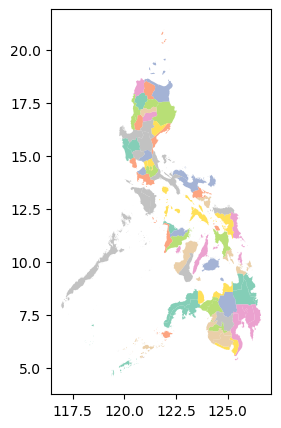

In [16]:
# we can use the built-in geopandas plot function to visualize
ax = data.plot(figsize=(10,5), alpha=0.8, cmap='Set2') # alpha is transparency 

currently the colors are assigned arbitrarily. However, we can also use colors to encode information. 

Let's first use colors to categorize by endangerment status. To do so, we pass the `column` argument to `plot()`. For reference, we also set `legend=True`

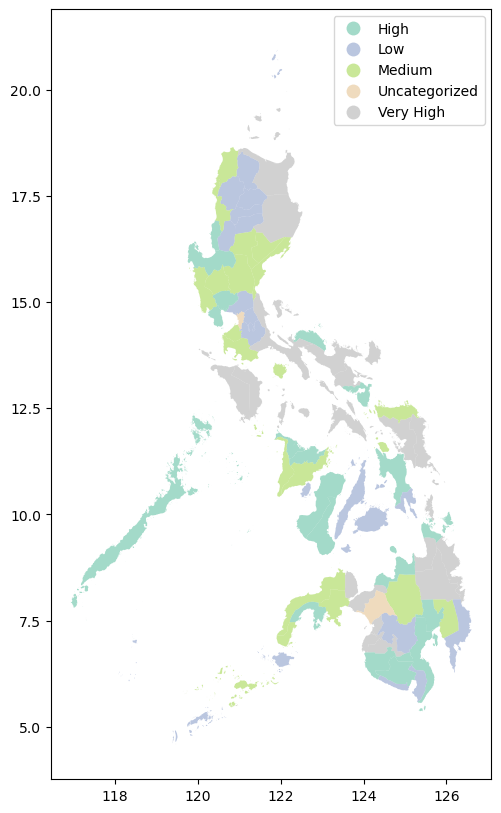

In [17]:
ax = data.plot(figsize=(10,10), alpha=0.6, cmap='Set2', column='FloodText', legend=True)

Another common use of colors to encode data is to represent numerical data in an area with colors. This is known as a [choropleth](https://en.wikipedia.org/wiki/Choropleth_map).

Let's use this to encode the areas of each region

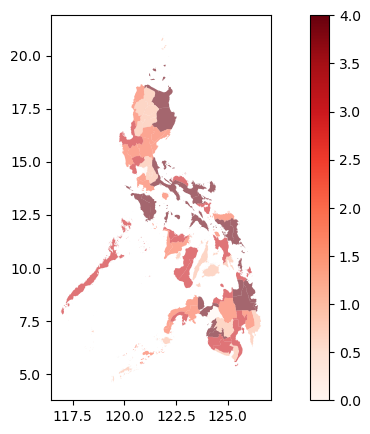

In [18]:
#then pass the area column as an argument
ax = data.plot(figsize=(10,5), alpha=0.6, cmap='Reds', column='FloodClass', legend=True)

The data by itself looks just like a bunch of blobs. Let's put it on a map for context

[Contextily](https://github.com/geopandas/contextily) is a library for creating basemaps. It pulls data from a host of different basemap providers - see [documentation](https://contextily.readthedocs.io/en/latest/) for more details.


In [19]:
# the data is currently in WGS84 (epsg:4326)
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

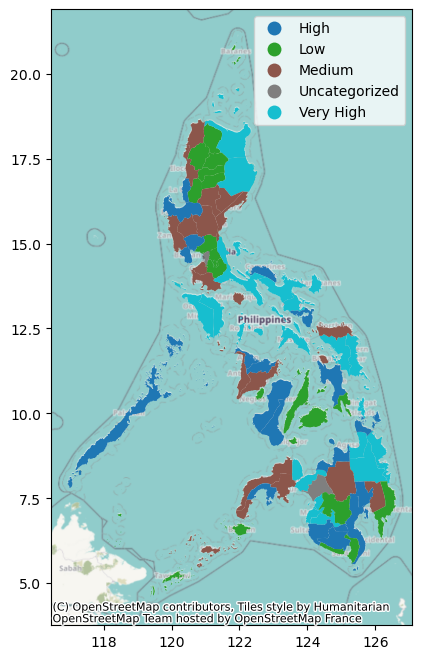

In [20]:
ax = data.plot(figsize=(10,8), column='FloodText', legend=True)
# now we add a basemap. ctx finds a basemap for a background from
# an online repository.
# It assumes the data is in web mercator (epsg:3857) unless you specify otherwise
ctx.add_basemap(ax, crs=data.crs)

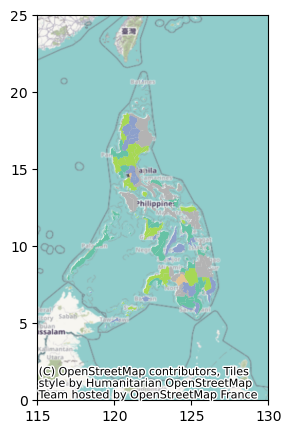

In [21]:
# we can set bounds using matplotlib
ax = data.plot(figsize=(10,5), cmap='Set2', column='FloodText')
ax.set_xlim([115,130])
ax.set_ylim([-0,25])
ctx.add_basemap(ax, crs=data.crs)

We can use different background styles:
![tile styles](https://contextily.readthedocs.io/en/latest/_images/tiles.png).

Note that some styles only contain labels or lines.

In [22]:
# to look at all of the different providers, check:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<insert 

previews of the different basemap styles can be viewed at: http://leaflet-extras.github.io/leaflet-providers/preview/ 

ValueError: Token is required for this provider, but not provided. You can either update TileProvider or pass respective keywords to build_url().

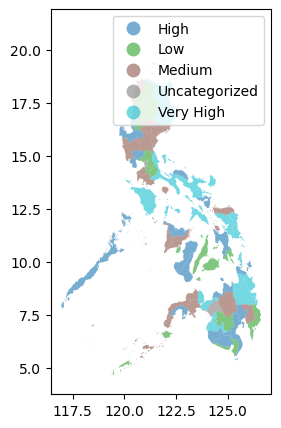

In [23]:
ax = data.plot(figsize=(10,5), alpha=0.6, column='FloodText', legend=True)
# to specify the type of basemap, specify the source argument
# the syntax is ctx.providers.{provider name}.{provider style}
ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.Thunderforest.Landscape) # replace Stamen with Thunderforest and Watercolor with Landscape
# you can add labels independently of the background
ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.CartoDB.DarkMatterOnlyLabels)

In [ ]:
# we can download background tiles as images for quicker loading (don't need to keep redownloading)
# let's use the bounds of the dataframe
w,s,e,n = data.total_bounds
data.total_bounds

the function bounds2img takes coordinates and [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) and downloads the corresponding tiles of the map as images

In [ ]:
img, ext = ctx.bounds2img(w, s, e, n, 6, ll=True, source=ctx.providers.Stamen.Watercolor) #ll means coordinates are in lat-lon
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img, extent=ext)
# bounds2img returns things in epsg:3857, so we need to plot the data in the same crs
data.to_crs(epsg=3857).plot(ax=ax, cmap='Set3', alpha=0.8)
ax_bounds = data.to_crs(epsg=3857).total_bounds
ax.set(xlim=[ax_bounds[0], ax_bounds[2]],ylim=[ax_bounds[1], ax_bounds[3]])
plt.axis('off')
plt.savefig('watercolor_example.png')

## Explore Interface
Geopandas also as an interactive interface for plotting maps using the `.explore()` function. The interface uses [folium](https://python-visualization.github.io/folium/) to plot an interactive map.

For full documentation on the `.explore()` function, see https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html

In [ ]:
!pip install folium matplotlib mapclassify

In [ ]:
# choose a column to visualize by passing in the column name
m = data.explore('FloodClass')
m # folium map object

You can set the basemap using the `tiles` keyword argument and providing an [xyzproviders](https://xyzservices.readthedocs.io/en/stable/api.html#xyzservices.TileProvider) TileProvider. 

See the gallery preview of all available providers [here](https://xyzservices.readthedocs.io/en/stable/gallery.html). Note that some require an API key with the given provider

In [ ]:
import xyzservices.providers as xyz
xyz

In [ ]:
data.explore('FloodClass', tiles=xyz.CartoDB.Voyager)

You can plot multiple layers of data onto the same map by passing the `folium` object into the `m=` keyword argument of `.explore()`. We will use another dataframe of health site locations in the philippines as our second layer.

In [ ]:
health_sites_gdf = gpd.read_file('philippines_healthsites.geojson', driver='GeoJSON')
health_sites_gdf

In [ ]:
# note that .explore() doesn't like timestamp objects
health_sites_gdf.explore()

In [ ]:
health_sites_gdf.dtypes

In [ ]:
# we can cast that column to string to get around it
health_sites_gdf['changeset_timestamp'] = health_sites_gdf['changeset_timestamp'].astype(str)

In [ ]:
# plotting both on the same folium map
m = data.explore('FloodClass', tiles=xyz.CartoDB.Voyager)
# you can select just a subset of columns to include
m = health_sites_gdf[['name',
                      'amenity',
                      'addr_street',
                      'addr_city',
                      'addr_postcode',
                      'healthcare',
                      'geometry']].explore(m=m)
m

In [ ]:
# you can set the dimensions of a map by creating a 
# folium object to initially draw on
data_centroid = data.dissolve().centroid.values[0] # dissolve combines all the geometries into one collection
m = folium.Map(location=(data_centroid.y, data_centroid.x),
               zoom_start=5,
                height=600, width=500) # in pixels
m = data.explore('FloodClass',
                 tiles=xyz.CartoDB.Voyager,
                 m=m,
                 name='Flood Class')
# you can select just a subset of columns to include
m = health_sites_gdf[['name',
                      'amenity',
                      'addr_street',
                      'addr_city',
                      'addr_postcode',
                      'healthcare',
                      'geometry']].explore(m=m,
                                          name='healthcare') # name of layer
# add a layer control menu
folium.LayerControl().add_to(m)
m

## Writing to a different file

First we'll make a directory for outputting data to. We use the `mkdir` command which makes an empty folder. The `-p` option will skip it if the directory already exists

In [ ]:
!mkdir output_data -p

In [ ]:
# let's write the first 20 rows of the shapefile to a new file
outfp = "output_data/data_selection.json"

# Select first 20 rows
selection = data[0:20]

# Write those rows into a new file - we will use the GeoJSON file type
selection.to_file(outfp, driver='GeoJSON')

## Converting shapes to GeoDataFrames
You can use Shapely geometric objects to create a GeoDataFrame from scratch. 

In [ ]:
# Create an empty geopandas GeoDataFrame
newdata = gpd.GeoDataFrame()

# add a geometry column (necessary for shapefile)
newdata['geometry'] = None

# Let's see what we have at the moment
print(newdata)

In [ ]:
# Coordinates of the MIT main campus in Decimal Degrees
coordinates = [(-71.092562, 42.357602), ( -71.080155, 42.361553), ( -71.089817, 42.362584), (-71.094688, 42.360198)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# Let's see what we have
poly

In [ ]:
# Insert the polygon into 'geometry' -column at index 0
newdata.loc[0, 'geometry'] = poly
newdata

In [ ]:
newdata.loc[0, 'location'] = 'MIT main campus'
newdata

Before exporting the data it is necessary to set the coordinate reference system (projection) for the GeoDataFrame. 

In [ ]:
# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
newdata = newdata.set_crs('epsg:4326')

# Let's see how the crs definition looks like
newdata.crs

In [ ]:
outfp = "output_data/MIT_campus.shp"

# Write the data into that Shapefile
newdata.to_file(outfp)

In [ ]:
# Let's plot it
ax = newdata.to_crs(epsg=3857).plot(figsize=(10,5),alpha = 0.5, color='#FF55FF')
ctx.add_basemap(ax)
ax.set_axis_off() # remove the x-y axes
plt.savefig('MIT_main_campus_poly.png')

# Exercise
Find an interesting GIS dataset and:
- visualize some raw data
- ask an interesting analysis question about it:
  - intersections, sizes, quantities
  - relationships
  - e.g. which latitudes contain the most endangered species? what countries have the most ports per km of coastline?
- Visualize some of your analysis
You can use the location you've chosen for your location fan-cam as a place of interest! 

Note that since geopandas is built on pandas, all of your knowledge from pandas should also carry over!

As per usual, we'll ask a few volunteers to present their results.

Here are some resources to look for GIS datasets:
- Cambridge, MA GIS data: http://cambridgegis.github.io/gisdata.html
- Awesome GIS data: https://github.com/sshuair/awesome-gis#data
- Humanitarian Data Exchange: https://data.humdata.org/
- Data.gov: https://www.data.gov/
Search for GeoJSON and/or Shapefile file types.

One tool to help draw GIS polygons is https://geojson.io; you can export your polygon as a geojson and upload it to your jupyter instance to access from jupyter.

In [34]:
#citibike_data = pd.read_csv("202406-citibike-tripdata_1.csv")

/tmp/ipykernel_83/707852703.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  citibike_data = pd.read_csv("202406-citibike-tripdata_1.csv")


In [98]:
"""
import numpy as np
citibike_data['member_casual'].astype(str)
np.unique(citibike_data["member_casual"])
"""
import pandas as pd
import glob

# Define the file path pattern to match all five CSV files
file_pattern = '202406-citibike-tripdata_1.csv'

# Use glob to get all file paths matching the patternx
file_paths = glob.glob(file_pattern)

# Specify data types for the affected columns
dtype = {
    'start_station_id': 'str',
    'end_station_id': 'str',
    'ride_id': 'str',
    'rideable_type': 'str',
    'started_at': 'str',
    'ended_at': 'str',
    'start_station_name': 'str',
    'end_station_name': 'str',
    'start_lat': 'float',
    'start_lng': 'float',
    'end_lat': 'float',
    'end_lng': 'float',
    'member_casual': 'str'
}

# Load and concatenate all CSV files into a single DataFrame
dfs = [pd.read_csv(file, dtype=dtype) for file in file_paths]

# Check if the DataFrames are loaded correctly
for i, df in enumerate(dfs):
    print(f"DataFrame {i+1} shape: {df.shape}")

# Combine the DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined dataframe
print(combined_df.head())

DataFrame 1 shape: (1000000, 13)
            ride_id  rideable_type               started_at  \
0  A38B171B6C31691A  electric_bike  2024-06-12 17:47:23.952   
1  77E13C9D6559EA56  electric_bike  2024-06-04 16:48:42.876   
2  EA6418AD826D19D9  electric_bike  2024-06-01 13:36:28.502   
3  121CF2548FB65A29   classic_bike  2024-06-01 03:12:09.636   
4  E6BE7FD2809649D6  electric_bike  2024-06-08 13:14:31.197   

                  ended_at           start_station_name start_station_id  \
0  2024-06-12 17:50:27.312              E 89 St & 3 Ave          7265.10   
1  2024-06-04 17:01:46.672  Pier 40 - Hudson River Park          5696.03   
2  2024-06-01 13:52:55.912              W 44 St & 5 Ave          6551.02   
3  2024-06-01 03:16:29.531      Graham Ave & Withers St          5403.04   
4  2024-06-08 13:24:09.858               E 9 St & Ave C          5616.01   

               end_station_name end_station_id  start_lat  start_lng  \
0               1 Ave & E 94 St        7286.05  40.780499 -

In [99]:
combined_df.groupby(['ride_id','member_casual'])['member_casual'].count()

ride_id           member_casual
00000E7CFAC55D21  member           1
0000316791C1AD70  member           1
000038C0DD53812C  casual           1
000063CCD9396C3D  casual           1
00007A743A276A35  member           1
                                  ..
FFFFD72B44B9BDDE  member           1
FFFFDE3A2D6D29AD  member           1
FFFFE294378815FF  member           1
FFFFFC58A0D97348  member           1
FFFFFF8C9DF273ED  casual           1
Name: member_casual, Length: 1000000, dtype: int64

In [100]:
# map
#combined_df = combined_df.reset_index()
combined_df.groupby(['ride_id'])
selected_df = combined_df[['start_lat','start_lng','end_lat','end_lng']]
selected_df
#base map of NYC 
ctx.providers
ctx.add_basemap(ax, crs=data.crs)
#ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.CartoDB.DarkMatterOnlyLabels)
#plot the start and coordinating end lat/lng of each unique ride using the ride ID
#lists of lat and long 
start_lat_list = combined_df['start_lat'].tolist()
start_lng_list = combined_df['start_lng'].tolist()
end_lat_list = combined_df['end_lat'].tolist()
end_lng_list = combined_df['end_lng'].tolist()
#make lines
"""patch1 = shapely.plotting.patch_from_polygon(poly_no_holes, facecolor='#1155FF', edgecolor='black', alpha=0.5)
ax1.add_patch(patch1)
ax1.set_xlim([-185, 185])
ax1.set_ylim([-95, 95])
"""
#explore

/opt/conda/lib/python3.11/site-packages/contextily/tile.py:570: RuntimeWarning: invalid value encountered in subtract
  lon_length = np.subtract(*lon_range)
/opt/conda/lib/python3.11/site-packages/contextily/tile.py:575: RuntimeWarning: divide by zero encountered in scalar divide
  zoom_lat = np.ceil(np.log2(360 * 2.0 / lat_length))


ValueError: cannot convert float NaN to integer

In [ ]:
# Sample a subset of the rides (e.g., 1000 rides)
sampled_df = combined_df.sample(n=1000, random_state=1)

# Create LineString geometries for each ride in the sample
sampled_df['ride_geometry'] = sampled_df.apply(lambda row: LineString([(row['start_lng'], row['start_lat']), (row['end_lng'], row['end_lat'])]), axis=1)
sampled_df

In [101]:
# Sample a subset of the rides (e.g., 1000 rides)
sampled_df = combined_df.sample(n=1000, random_state=1)

# Create LineString geometries for each ride in the sample
sampled_df['ride_geometry'] = sampled_df.apply(
    lambda row: LineString([(row['start_lng'], row['start_lat']), (row['end_lng'], row['end_lat'])]), axis=1)

# Create a GeoDataFrame for the sampled data
gdf_lines_sampled = gpd.GeoDataFrame(sampled_df, geometry='ride_geometry', crs='EPSG:4326')

# Display the first few rows of the sampled GeoDataFrame to verify
print(gdf_lines_sampled.head())

                 ride_id  rideable_type               started_at  \
276826  7EA2BF40FEA25425  electric_bike  2024-06-02 13:58:05.742   
849425  1B06F3A40E143A41   classic_bike  2024-06-01 07:42:54.838   
504499  9F486785BACD0C4D  electric_bike  2024-06-05 17:53:29.867   
601054  F65A90BDCB8E2C03   classic_bike  2024-06-14 15:20:22.421   
980221  9076204C226BB806  electric_bike  2024-06-01 20:43:49.757   

                       ended_at     start_station_name start_station_id  \
276826  2024-06-02 14:19:54.908  Forsyth St & Canal St          5270.07   
849425  2024-06-01 07:50:55.093        W 31 St & 7 Ave          6331.01   
504499  2024-06-05 17:54:52.150  E 66 St & Madison Ave          6969.08   
601054  2024-06-14 15:30:17.944        E 11 St & 1 Ave          5746.14   
980221  2024-06-01 20:57:42.737     W 63 St & Broadway          7052.01   

                 end_station_name end_station_id  start_lat  start_lng  \
276826            E 40 St & 5 Ave        6474.11  40.715871 -73.99

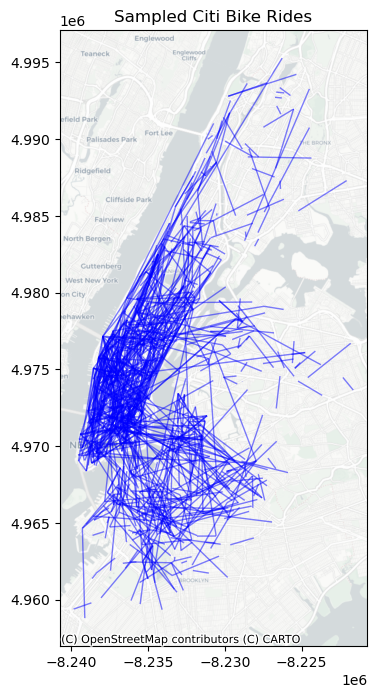

In [102]:
# Convert the GeoDataFrame to Web Mercator (EPSG:3857)
gdf_lines_sampled = gdf_lines_sampled.to_crs(epsg=3857)

# Plot the sampled rides
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_lines_sampled.plot(ax=ax, linewidth=1, alpha=0.5, color='blue')

# Add basemap
ctx.add_basemap(ax, crs=gdf_lines_sampled.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.title('Sampled Citi Bike Rides')
plt.show()

### Covid-19 Resources
For those interested in how GIS can be used to analyze the pandemic, here are some ideas and data:

*   Visualize raw data collected from sources around the world about the state of the pandemic
*   Explore connections between various factors and come up with a hypothesis for your research. Some ideas could be connecting COVID data in different counties to socioeconomy, age, or building architecture data. Remember, mapping data speaks louder than graphs or datasets.
*   Present your findings to the rest of the class and come up with a possible solution to the problem or connection that you explored

COVID-19 Datasets:
* COVID-19 Dataset (Kaggle): www.kaggle.com/imdevskp/corona-virus-report
* New York Times Dataset: https://github.com/nytimes/covid-19-data
* JHU Dataset: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
*  Feel free to explore more area specific datasets or datasets which outline other conditions. These are just suggestions.

To make your research connections, be sure to explore population and demographic datasets of different counties around the country. Be creative with your research!